# Simex NOVSL
For running SUMO adjust the path in the `global_settings.py` file. The global_settings.py file also contains the parameters to be set for the simulation such as interval list.

## Important settings
Ajust the sumo path:
```python
# SUMOvsl settings
sumovsls = {"model_path": "C:/Users/kusic/Desktop/SSF/SUMOVSL/SPSC_MD/model_MD/",
           "sumo_path": "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo"} # sumo or sumo-gui
```

Setting the min/max domain interval and increment unit for the modifiers:
```python
# Modifier Domain Settings
mds = {"domain_min_interval": 2500,
       "domain_max_interval": 4000,
       "modifier_incremental_unit": 25, #increment
       "modifier_data_point": 100 # ID
       }
```
Setting the threshold for the validator:
```python
# Validator Function Settings
vfs = {'threshold_y_fitting': 15,
       'threshold_x_interval': 0.80,
       'degree': 2,
       'max_deg': 9,
       'early_stop': True,
       'improvement_threshold': 0.1,
       'penality_weight': 1}
```

In [ ]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

validator_controller_novsl = ValidatorController("NOVSL")
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]
#intervals_list=[[2900, 3200]]
# Values for the timestamp of the pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

while is_main_func:
    
    # Calls Modifier Controller
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate(mod_x_list,selected_simulator=components['sumo_simulator_novsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_novsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number (loop-1,loop2..etc)
    count +=1
    save_object(validator_controller_novsl,f"vc_novsl_loop-{count}-{filename1}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)


Modifier...
[MODC]: intervals list:  [[2500, 4000]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4000)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]
[MODC]: mod_x:  [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]
MAIN mod outcome ([[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]], [[2500, 4000]])
Simulator...
[[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 36

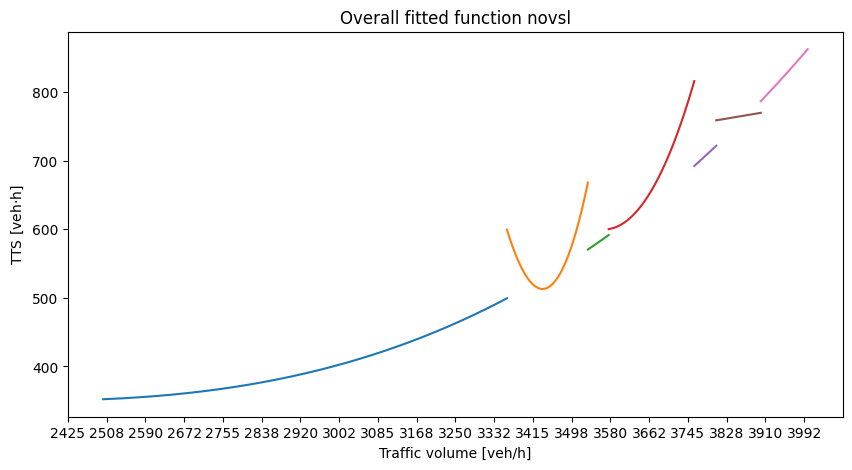

In [12]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from global_settings import lgs, mgs


all_fit_intervals_data = logger.all_fit_intervals_data
remaining_unfit_intervals = logger.remaining_unfit_intervals
_, ax = plt.subplots(figsize=(10, 5))

# Plot FI intervals with their fitting functions
for element in all_fit_intervals_data:
    interval = element['interval']
    fitting_function_str = element['fitting_function']

    # Convert the string into a function
    terms = re.findall(
        r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', fitting_function_str.replace(' ', ''))
    coefficients = [0] * 10  # Initialize a list of 10 zeros
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    # Reverse the list to match the order expected by np.poly1d
    fitting_function = np.poly1d(coefficients[::-1])

    # Adjust the number of points as needed
    x = np.linspace(interval[0], interval[1], 400)
    y = fitting_function(x)
    ax.plot(x, y, label=f'Interval: {interval}')
    #plt.ylim([-100, 100])
    ax.set_xticks(np.arange(*ax.get_xlim(),
                            (ax.get_xlim()[1] - ax.get_xlim()[0]) / 20))

for element in remaining_unfit_intervals:
    ax.axvspan(*element['interval'], color='gray',
               alpha=0.3, label='unfit Interval')
plt.title("Overall fitted function novsl")
plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.savefig(f"total_function-novsl.pdf", format='pdf')

In [13]:
save_object(logger.all_fit_intervals_data,"logger-novsl.pkl")

In [ ]:
vsl